# Analyze A/B Test Results 


- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)

<a id='probability'></a>
## Part I - Probability

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import statsmodels.api as sm

%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

<center>

|Data columns|Purpose|Valid values|
| ------------- |:-------------| -----:|
|user_id|Unique ID|Int64 values|
|timestamp|Time stamp when the user visited the webpage|-|
|group|In the current A/B experiment, the users are categorized into two broad groups. <br>The `control` group users are expected to be served with `old_page`; and `treatment` group users are matched with the `new_page`. <br>However, **some inaccurate rows** are present in the initial data, such as a `control` group user is matched with a `new_page`. |`['control', 'treatment']`|
|landing_page|It denotes whether the user visited the old or new webpage.|`['old_page', 'new_page']`|
|converted|It denotes whether the user decided to pay for the company's product. Here, `1` means yes, the user bought the product.|`[0, 1]`|
</center>

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [3]:
df.shape[0]

294478

In [4]:
df['user_id'].nunique()

290584

In [5]:
df.converted.mean()

0.11965919355605512

In [6]:
num_of_mismatch = df.query('group == "treatment" & landing_page != "new_page"').shape[0]
num_of_mismatch

1965

In [7]:
df.isnull().any(axis = 1).sum()

0

In [8]:
# Remove the inaccurate rows, and store the result in a new dataframe df2
inaccurate_rows = df.query('group == "treatment" & landing_page != "new_page"').index
inaccurate_rows = inaccurate_rows.union(df.query('group == "control" & landing_page != "old_page"').index)
df2 = df.drop(inaccurate_rows)

In [9]:
# Double Check all of the incorrect rows were removed from df2 - 
# Output of the statement below should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [10]:
df2['user_id'].nunique()

290584

In [11]:
df2[df2.duplicated(['user_id'])].user_id

2893    773192
Name: user_id, dtype: int64

In [12]:
df2[df2.duplicated(['user_id'])]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [13]:
# Remove one of the rows with a duplicate user_id..
# Hint: The dataframe.drop_duplicates() may not work in this case because the rows with duplicate user_id are not entirely identical. 

deleted_indexes = df2[df2.duplicated(['user_id'])].index.values
df2 = df2.drop(labels = deleted_indexes, axis=0)

# Check again if the row with a duplicate user_id is deleted or not
df2[df2.duplicated(['user_id'])].shape[0]

0

the probability of an individual converting regardless of the page they receive?<br><br>
$p_{population}$.

In [14]:
df2.converted.mean()

0.11959708724499628

In [15]:
control_group = df2.query('group == "control"')
control_group.converted.mean()

0.1203863045004612

In [16]:
treatment_group = df2.query('group == "treatment"')
treatment_group.converted.mean()

0.11880806551510564

In [17]:
# Calculate the actual difference (obs_diff) between the conversion rates for the two groups.
obs_diff = treatment_group.converted.mean() - control_group.converted.mean()
obs_diff

-0.0015782389853555567

In [18]:
received_newpage_prob = df2.query('landing_page == "new_page"').shape[0] / df2.shape[0]
received_newpage_prob

0.5000619442226688

>**from the obs_diff value it does not lead to more conversions but we need to do more tests to decide, we can't take a decision based on the proportion.**

<a id='ab_test'></a>
## Part II - A/B Test


we want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%

>**H0 : $p_{new}$ <= $p_{old}$**

>**H1 : $p_{new}$ > $p_{old}$**

### Null Hypothesis $H_0$ Testing


In [19]:
p_new = df2.converted.mean()
p_new

0.11959708724499628

In [20]:
p_old = df2.converted.mean()
p_old

0.11959708724499628

In [21]:
n_new = df2.query('group == "treatment"').shape[0]
n_new

145310

In [22]:
n_old = df2.query('group == "control"').shape[0]
n_old

145274

**Simulate Sample for the `treatment` Group**<br> 

In [23]:
# Simulate a Sample for the treatment Group
new_page_converted = np.random.choice(2, size = n_new, p = [1-p_new, p_new])

**Simulate Sample for the `control` Group** <br>

In [24]:
# Simulate a Sample for the control Group
old_page_converted = np.random.choice(2, size = n_old, p = [1-p_old, p_old])

**the difference in the "converted" probability $(p{'}_{new}$ - $p{'}_{old})$ for the simulated samples**

In [25]:
new_page_converted.mean() - old_page_converted.mean()

0.0015943944471036725


**Sampling distribution** <br>


In [26]:
# Sampling distribution 
p_diffs = []
for _ in range(10000):
    new_page_converted = np.random.choice(2, size = n_new, p =[1-p_new, p_new])
    old_page_converted = np.random.choice(2, size = n_old, p =[1-p_old, p_old])
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())

Text(0, 0.5, 'number of occurences')

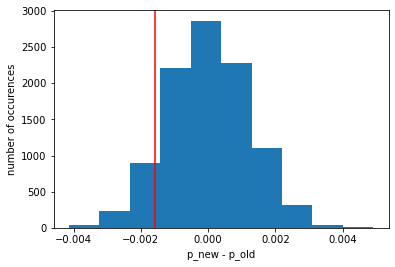

In [27]:
plt.hist(p_diffs)
plt.axvline(obs_diff, c="red")
plt.xlabel('p_new - p_old')
plt.ylabel('number of occurences')

In [28]:
np.array([True for x in p_diffs if x > obs_diff]).shape[0] / len(p_diffs)
# (p_diffs > obs_diff).mean()

0.906

>**this is called the P-value**

>**it signifies that there is not a significant difference between the new and old pages, because the area under the curve shows P is greater than alpha so we failed to reject the null hypothesis (pnew <= pold)**



**Using Built-in Methods for Hypothesis Testing**<br>


In [29]:
import statsmodels.api as sm

# number of conversions with the old_page
convert_old = df2.query('landing_page == "old_page" & converted == 1').shape[0]

# number of conversions with the new_page
convert_new = df2.query('landing_page == "new_page" & converted == 1').shape[0]

# number of individuals who were shown the old_page
n_old = df2.query('landing_page == "old_page"').shape[0]

# number of individuals who received new_page
n_new = df2.query('landing_page == "new_page"').shape[0]

print(convert_old, convert_new, n_old, n_new)

17489 17264 145274 145310


In [30]:
import statsmodels.api as sm
# ToDo: Complete the sm.stats.proportions_ztest() method arguments
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')
print(z_score, p_value)

-1.3109241984234394 0.9050583127590245


>**it is a right tail, and Z-score < Zalpha so we failed to reject the null hypothesis that there is not a significant difference between the old and new page conversion rates.** 

>**Also from the z-score table, we can find the proportion (the area to the left) is 0.095 but we want the area to the right
(1-0.095) = 0.905 which is the p-value, so this means that there is not a significant difference between the old and new page
since the p-value > 0.05 we fail to reject the null hypothesis.**

>**yes, they agree with the findings above in parts j, k**

<a id='regression'></a>
### Part III - A regression approach


In [31]:
df2['intercept'] = 1
df2['ab_page'] = pd.get_dummies(df['group'])['treatment']
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


In [32]:
log_reg = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = log_reg.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


In [33]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.3502
Date:               2022-10-16 18:16 BIC:              212801.5095
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290582           LLR p-value:      0.18988    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

>**p-value = 0.1899**

>**H0 : B1 = 0**

>**H1 : B1 != 0**

**in part3 the null hypothesis assumes that the ab_page column is not significant, and the alternate that the column is significant in predicting if the user converted or not**

**in part2 the null hypothesis assumes the old page conversion rate is better, and we want to prove in the alternative that the new page conversion is better**

**in part3 they are two-sided unlike part2**

**the p-value is greater than 0.05, we fail to reject H0, so this column is not significant in predicting if a user converts or not**

>**we should try to add more explanatory variables to improve our model prediction because the ab_page failed to do that.**

>**we should take care of disadvantages for example multicollinearity, the input variables should not be dependent on each other.**

**Adding countries**<br> 

In [34]:
# Read the countries.csv
df3 = pd.read_csv('countries.csv')

In [35]:
# Join with the df2 dataframe
df_merged = df2.join(df3.set_index('user_id'), on='user_id')

In [36]:
# Create the necessary dummy variables
df_merged[['CA', 'UK', 'US']] = pd.get_dummies(df_merged['country'])
df_merged.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1


In [37]:
# Fit your model, and summarize the results
df_merged['intercept'] = 1

df_merged['US_ab_page'] = df_merged['US'] * df_merged['ab_page']
df_merged['CA_ab_page'] = df_merged['CA'] * df_merged['ab_page']

log_reg = sm.Logit(df_merged['converted'], df_merged[['intercept', 'ab_page', 'CA', 'US', 'US_ab_page', 'CA_ab_page']])
results = log_reg.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212782.6602
Date:               2022-10-16 18:16 BIC:              212846.1381
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           5                LL-Null:          -1.0639e+05
Df Residuals:       290578           LLR p-value:      0.19199    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9922    0.0161  -123.4571  0.0000  -2.0238  -1.9606
ab_page       0.0108    0.0228     0.4749  0.6349  -0.0339   0.0555
CA           -0.0118    0.0398    -0.2957  0.7674  -0.0899   0.0663
US            0.0057    0.0188     0.3057  0.7598  -0.0311   0.0426
US_ab_page   -0.0314    0.0266    -1.1807  0.2377  -0.0835   0.0207
CA_ab_page   -0.0783    0.0568    -1.3783  0.1681  -0.1896   0.0330
==================================================================

"""

>**all p-values are greater than 0.05**

>**so we fail to reject the null hypothesis, which means these columns are not significant in predicting wheter user converts or not.**